This notebook will load data, perform a tidal analyis, compare with observations, plot the results, and save the analysis in a spreadsheet.  Eight Tidal Constituents: M2, K1, O1, S2, P1, N2, Q1 and K2 are considered.
- Links consistuents that cannot be separated over 40 days
- Corrects nodal calculations

In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as NC
from scipy.optimize import curve_fit
from salishsea_tools import tidetools
from salishsea_tools import viz_tools
from salishsea_tools import bathy_tools
from salishsea_tools import nc_tools
#from nowcast import figures
import scipy.io as sio
import collections
import pandas as pd
import csv
import math


/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Run Details

First, let's define the run that we will be analyzing. We can analyze a different run by changing runname in the cell below. A spreadsheet called tide_runs.ods contains a list of runs that we can look at.

In [2]:
# pathname for data - all of the tide runs are stored in this directory
#path = '/data/nsoontie/MEOPAR/SalishSea/results/tides/'
path = '/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/'

#the run we want to analyze
runname = 'a3'
nemo = '3.6'
start = 'apr2016'   # 'oct2002' or 'apr2003' 'dec2015' 'apr2016'

#joining the two string together
name = path +runname +'/'

print (name)
if nemo == '3.4':
    timeinc = 0
elif nemo == '3.6':
    if start == 'dec2015':
        timeinc = 3659558400
    elif start == 'apr2003':
        timeinc = 3259872000.
    elif start == 'apr2016':
        timeinc =  3668716800  # time 1900-1970 = 2208988800 and epoch.com for the rest
    
TSout = {'West': {'M2': {'Amp': 0, 
                        'Pha': 0},
                  'K1': {'Amp': 0,
                        'Pha': 0},
                  'O1': {'Amp': 0,
                        'Pha': 0},
                  'S2': {'Amp': 0,
                        'Pha': 0},
                  'N2': {'Amp': 0,
                        'Pha': 0},
                  'Q1': {'Amp': 0,
                         'Pha': 0}
                  },
         'North': {'M2': {'Amp': 0, 
                        'Pha': 0},
                  'K1': {'Amp': 0,
                        'Pha': 0},
                  'O1': {'Amp': 0,
                        'Pha': 0},
                  'S2': {'Amp': 0,
                        'Pha': 0},
                  'N2': {'Amp': 0,
                        'Pha': 0},
                  'Q1': {'Amp': 0,
                         'Pha': 0}
                  }
        }

/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/


We'll also load the bathymetry data in case we want to look at that. The package **tidetools** has a function get_SS_bathy_data() that returns bathymetry and grid data.

In [3]:
# grid
grid = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/nemo-forcing/grid/bathy_downonegrid2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

# Observations



Next, we can load some observations from a text file: /data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv Note: This file contains a mix of M2/K1 measurements from Foreman et al (1995), US tidal harmonics, Foreman et al (2004) and Foreman et al (2012) (for Northern tides).


In [4]:
filename = '../compare_tides/obs_tidal_wlev_const_all.csv'

harm_obs = pd.read_csv(filename,sep=';',header=0)
harm_obs = harm_obs.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'M2 amp': 'M2_amp', 'M2 phase (deg UT)': 'M2_pha',
                                   'K1 amp': 'K1_amp', 'K1 phase (deg UT)': 'K1_pha'})
print (harm_obs)

                  site       lat       lon  M2_amp  M2_pha  K1_amp  K1_pha
0                Sooke  48.36700  123.7330    43.8   282.7    56.9   266.4
1         Port Angeles  48.12500  123.4400    51.8   307.4    66.9   261.4
2           Pedder Bay  48.33100  123.5490    34.2   308.0    62.7   269.0
3            Esquimalt  48.43300  123.4330    36.7   317.1    64.3   268.1
4         Clover Point  48.40500  123.3470    40.3   320.3    64.2   269.8
5             Victoria  48.41700  123.3670    37.3   316.1    62.7   269.2
6        Finnerty Cove  48.47300  123.2950    44.7   357.7    70.8   277.5
7        Port Townsend  48.14500  122.7550    65.2   350.0    75.0   270.8
8               Sidney  48.65000  123.4000    55.4     5.9    76.7   277.6
9         Patricia Bay  48.65000  123.4500    60.3    14.4    76.0   281.3
10           Maple Bay  48.81700  123.6170    68.5    17.0    79.3   281.2
11     Fulford Harbour  48.76700  123.4500    58.2    12.7    75.3   280.0
12           Ladysmith  4

This is a list of observations that we can compare with our model output. Now we have a struc object called harm_obs that contains the data printed above.

In [5]:
filename = '../Idalia/other_constituents.csv'

harm_other = pd.read_csv(filename,sep=',',header=0)
harm_other = harm_other.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'O1 amp': 'O1_amp', 'O1 phase (deg UT)': 'O1_pha',
                                    'P1 amp': 'P1_amp', 'P1 phase (deg UT)': 'P1_pha',
                                    'Q1 amp': 'Q1_amp', 'Q1 phase (deg UT)': 'Q1_pha',
                                    'S2 amp': 'S2_amp', 'S2 phase (deg UT)': 'S2_pha',
                                    'N2 amp': 'N2_amp', 'N2 phase (deg UT)': 'N2_pha',
                                    'K2 amp': 'K2_amp', 'K2 phase (deg UT)': 'K2_pha'})
print (harm_other)

                  site     lat      lon  O1_amp  O1_pha  P1_amp  P1_pha  \
0             Neah Bay  48.385 -124.616   30.90  231.50   15.50  244.60   
1         Port Renfrew  48.537 -124.476   28.30  234.80   14.07  250.60   
2         Port Angeles  48.129 -123.400   39.10  241.60   20.70  259.40   
3             Victoria  48.413 -123.399   37.00  247.80   19.70  264.60   
4        Port Townsend  48.112 -122.758   45.00  249.90   23.90  268.40   
5               Bangor  47.748 -122.727   46.60  251.90   26.00  273.90   
6              Seattle  47.605 -122.338   45.80  255.40   25.20  274.50   
7               Tacoma  47.267 -122.413   45.90  255.10   25.50  277.20   
8         Cherry Point  48.863 -122.758   45.60  260.00   25.60  281.40   
9        Friday Harbor  48.540 -123.010   42.30  256.40   23.60  274.90   
10       Hanbury Point  48.580 -123.172   43.60  253.60   23.40  271.40   
11              Sidney  48.658 -123.383   44.40  255.80   24.20  275.20   
12     Fulford Harbour  4

# Model

We don't have model output at all of the above locations. The model outputs are listed below. There is a location.nc file in the run directory for each of the stations listed below.

In [36]:
stations =  ['PortRenfrew','SheringhamPoint','PedderBay', 'Esquimalt',
             'Victoria','CloverPoint','FinnertyCove', 'FulfordHarbour',
            'TumboChannel','PatosIsland','WhalerBay', 'Tsawwassen',
              'Sandheads', 'PointGrey','PointAtkinson','GibsonsLanding', #'WinchelseaIs',
             'HalfmoonBay','IrvinesLanding','PowellRiver', #'LittleRiver', 
               'Lund',
              'TwinIslets','CampbellRiver','MaudeIslandE', 'NympheCove',
              'SeymourNarrows','BrownBay','ChathamPoint','KelseyBay',
               'YorkeIsland']
numsta=len(stations)
#again with spaces because the text file likes that
stations_obs =  ['Port Renfrew','Sheringham Point','Pedder Bay', 'Esquimalt',
                   'Victoria','Clover Point','Finnerty Cove', 'Fulford Harbour',
                    'Tumbo Channel','Patos Island','Whaler Bay', 'Tsawwassen',
                   'Sandheads', 'Point Grey','Point Atkinson','Gibsons Landing', #'Winchelsea',
                    'Halfmoon Bay','Irvines Landing','Powell River', #'Little River', 
                     'Lund',
                    'Twin Islets','Campbell River','Maude Island E', 'Nymphe Cove',
                    'Seymour Narrows','Brown Bay','Chatham Point','Kelsey Bay',
                 'Yorke Island']
for i, station in enumerate(stations_obs):
    print (i, station)

0 Port Renfrew
1 Sheringham Point
2 Pedder Bay
3 Esquimalt
4 Victoria
5 Clover Point
6 Finnerty Cove
7 Fulford Harbour
8 Tumbo Channel
9 Patos Island
10 Whaler Bay
11 Tsawwassen
12 Sandheads
13 Point Grey
14 Point Atkinson
15 Gibsons Landing
16 Halfmoon Bay
17 Irvines Landing
18 Powell River
19 Lund
20 Twin Islets
21 Campbell River
22 Maude Island E
23 Nymphe Cove
24 Seymour Narrows
25 Brown Bay
26 Chatham Point
27 Kelsey Bay
28 Yorke Island


Next, we can plot these locations on a map of our domain.

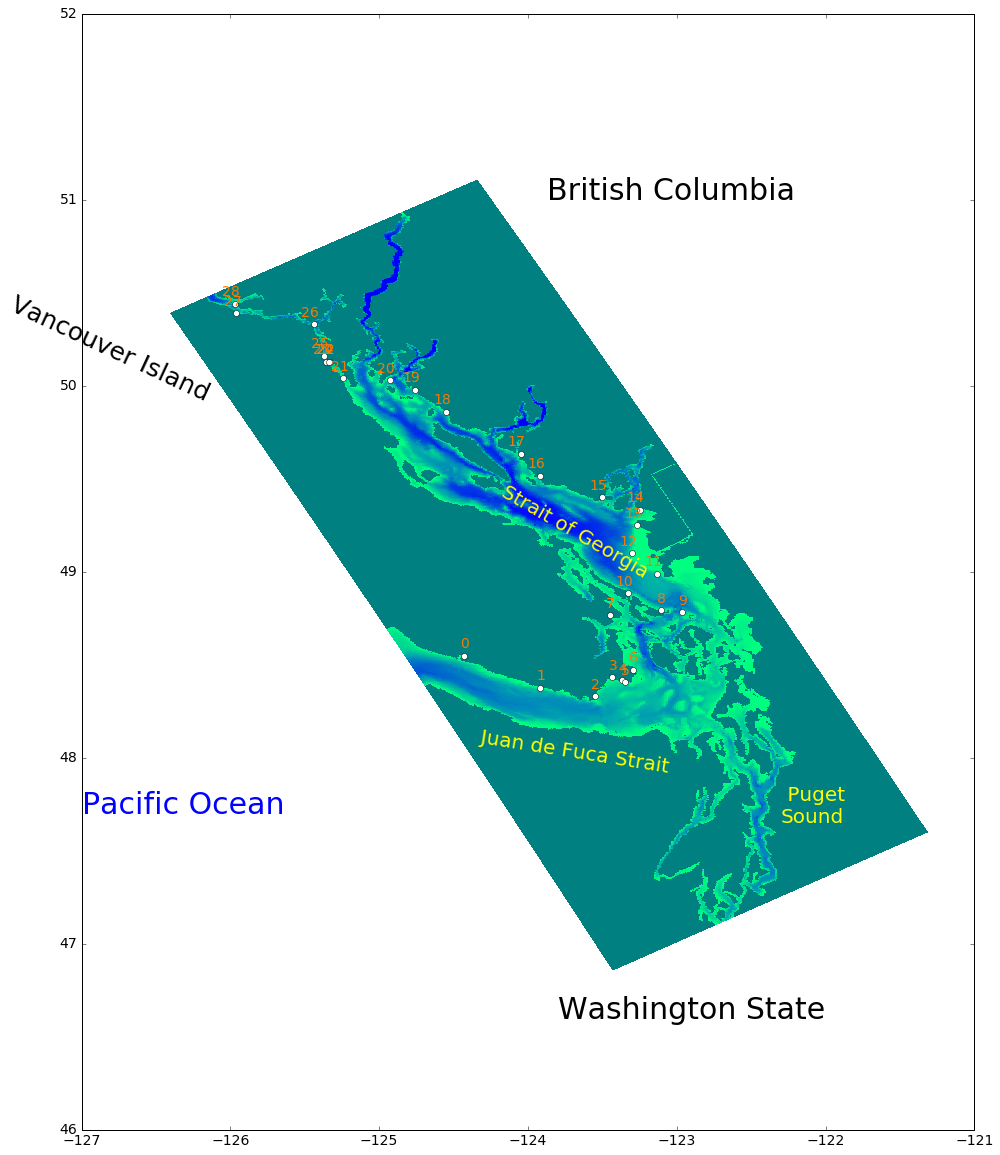

In [7]:
fig,ax=plt.subplots(1, 1, figsize=(16, 20))
cmap = plt.get_cmap('winter_r')
cmap.set_bad('teal')

PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

#figures.plot_map(ax, PNW_coastline, lat_range=(46.5, 52), lon_range=(-128.5, -121.5))
ax.pcolormesh(X,Y,bathy,cmap=cmap)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)



for stn in range(numsta):
    location = stations_obs[stn]
    lon=-harm_obs.lon[harm_obs.site==location]
    lat=harm_obs.lat[harm_obs.site==location]
    ax.plot(lon,lat,'ow',label=location)
    ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
        textcoords = 'offset points', fontsize=14, color='#F87902')

ax.text(
        -127, 47.7,
        'Pacific Ocean',
        fontsize=30, color='blue')
ax.text(
        -124., 51,
        '  British Columbia',
        fontsize=30, color='black')
ax.text(
        -123.8, 46.6, 'Washington State',
        fontsize=30, color='black')
ax.text(
        -122.3, 47.65, ' Puget\nSound',
        fontsize=20, color='yellow')
ax.text(
        -124.5, 48.1,
        '    Juan de Fuca Strait',
        fontsize=20, color='yellow', rotation=-9)
ax.text(
        -124.2, 49.4,
        'Strait of Georgia',
    fontsize=20, color='yellow', rotation=-30)

ax.text(
        -127.5, 50.4,
        'Vancouver Island',
    fontsize=25, color='black', rotation=-25)


In [39]:
# set the split that defines Juan de Fuca and the North

split1=8; split2=21
print (split1, split2)

# define range for main SoG
SoG1 = 11
SoG2 = 20
print (stations_obs[11], ' to ', stations_obs[20])

8 21
Tsawwassen  to  Twin Islets


# Tidal Harmonics

/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/
Sandheads
(5760,)
0.253305
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/
PointGrey
(5760,)
0.314301
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/
PointAtkinson
(5760,)
0.309642
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/
GibsonsLanding
(5760,)
0.311214
0.0833333333333 3668717100.0 3668716800


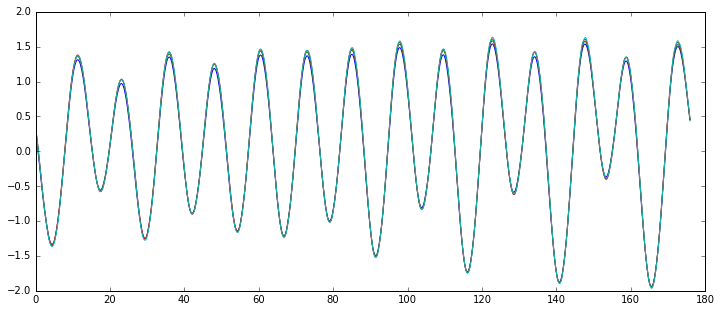

In [9]:
sday=2-1; eday = 23-1
fig, ax = plt.subplots(1,1,figsize=(12,5))
for stn in range(12, 16):
    print (name)
    print (stations[stn])
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = (fT1.variables["time_counter"][:]-timeinc)/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]
    print (ssh.shape)
    print (ssh[0])
    ax.plot(time[(sday-1)*24*2:eday*24*2],ssh[(sday-1)*24*2:eday*24*2])
print (time[0], fT1.variables['time_counter'][0], timeinc)

We need a way of determing the amplitude and phase of M2/K1/O1/S2 from our model output. We will do this by fitting our model water levels to cosine curves with the known frequency of M2/K1/O1/S2.

In [10]:
#constants and fitting
# M2
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
#K1
K1freq = 15.041069*np.pi/180.
#O1
O1freq = 13.943036*np.pi/180.
#S2
S2freq = 30.000002*np.pi/180.
#P1
P1freq = 14.958932*np.pi/180.
#N2
N2freq = 28.439730*np.pi/180.
#Q1
Q1freq = 13.398661*np.pi/180.
#K2
K2freq = 30.082138*np.pi/180.

# initial phase calculation
# our start is currently Oct 26, 2002
# data for phase output from bdytides.F90; found in ocean.output
# NEMO 3.4 writes out in degrees, NEMO 3.6 writes out in radians
# NEMO 3.6 ut phase of tide due to nodes, vt phase of tide relative to Greenwich
# first one printed out is stable, second one is varying fast
# first on is ut second one is vt
if start == 'oct2002':
    K1ft = 1.050578
    K1uvt = 296.314842
    M2ft = 0.987843
    M2uvt = 245.888564
    O1ft = 1.081364
    O1uvt = 312.950020
    S2ft = 1.0
    S2uvt = 0.0
    P1ft = 1.0
    P1uvt = 55.79460
    N2ft = 0.98784
    N2uvt = 353.570277
    Q1ft = 1.081364
    Q1uvt = 60.631733
    K2ft = 1.114095
    K2uvt = 52.129248

# for start of Apr 21, 2003
elif start == 'apr2003':

    K1ft = 1.065505                  # 1.072
    K1uvt = 111.481741   
    M2ft = 0.982328                  # 0.980
    M2uvt = 250.506179
    O1ft = 1.105495                  #1.114
    O1uvt = 142.040782               #52.748
    S2ft = 1.000000                  # 1.001
    S2uvt = 0.000000
    P1ft = 1.000000                 # 0.994
    P1uvt = 241.335269              #349.125
    N2ft = 0.982328                 # 0.977
    N2uvt = 205.684028
    Q1ft = 1.105495                 #1.092
    Q1uvt = 97.218631               # 3.397
    K2ft = 1.159036                 # 1.18
    K2uvt = 42.361669
    
elif start == 'dec2015':
    
    M2ft = 1.03774639446235                                                         # 1.038
    M2uvt = (-12.5687951531251+15.0747977989126)*180./np.pi     
    S2ft = 1.00000000000000                                                         # 0.998
    S2uvt = (0.000000000000000+6.28609418926624)*180./np.pi     
    N2ft = 1.03774639446235                                                         # 1.034
    N2uvt = (-12.5687951531251+15.0140965178508)*180./np.pi     
    K1ft = 0.882044509440140                                                        # 0.882
    K1uvt = (-1.198932264051458E-002+6.25441043983728)*180./np.pi     
    O1ft = 0.806243380430995                                                        # 0.802
    O1uvt = (-12.5500821639088 + 8.82038735907528)*180./np.pi
    Q1ft = 0.806243380430995                                                        # 0.801
    Q1uvt = (-12.5500821639088 + 8.75968607801354)*180./np.pi     
    K2ft = 0.746702716634735                                                        # 0.749
    K2uvt = (-2.156203094515553E-002 + 15.6504135332644)*180./np.pi     
    P1ft = 1.00000000000000                                                         #1.011
    P1uvt = (0.000000000000000E+000 + 3.168374942895902E-002)*180./np.pi
 
# http://www.pac.dfo-mpo.gc.ca/science/oceans/tidal-marees/facteur-node-factor-eng.html

# M2    -12.5723919058578        1.03732080029941       -4.89942876430390     
#  1.405189025756747E-004
# S2    0.000000000000000E+000   1.00000000000000        6.28609418926624     
#  1.454441043328608E-004
# N2    -12.5723919058578        1.03732080029941       -10.2814509926160     
#  1.378796995658846E-004
# K1   -2.970455525086256E-002  0.883788775988112        1.79472099466869     
#  7.292115854679635E-005
# O1    -12.5260869169596       0.809167374358197       -6.69414975897259     
#  6.759774402887834E-005
# Q1    -12.5260869169596       0.809167374358197       -12.0761719872846     
#  6.495854101908828E-005
# K2   -5.353205371726932E-002  0.749362153177437        6.73103464292718     
#  1.458423170935927E-004
# P1    0.000000000000000E+000   1.00000000000000        4.49137319459755     
#  7.252294578606445E-005
elif start == 'apr2016':
    M2ft = 1.03732080029941
    M2uvt = (-12.5723919058578 -4.89942876430390)*180./np.pi
    S2ft = 1.00000000000000
    S2uvt = (0.000000000000000E+000 + 6.28609418926624)*180./np.pi
    N2ft = 1.03732080029941
    N2uvt = (-12.5723919058578 -10.2814509926160)*180./np.pi
    K1ft = 0.883788775988112
    K1uvt = (-2.970455525086256E-002 + 1.79472099466869)*180./np.pi
    O1ft = 0.809167374358197 
    O1uvt = (-12.5260869169596 -6.69414975897259)*180./np.pi
    Q1ft = 0.809167374358197
    Q1uvt = (-12.5260869169596 -12.0761719872846)*180./np.pi
    K2ft = 0.749362153177437
    K2uvt = (-5.353205371726932E-002 + 6.73103464292718)*180./np.pi
    P1ft = 1.00000000000000
    P1uvt = (0.000000000000000E+000 + 4.49137319459755)*180./np.pi

However, with our typical 40-day output, we cannot separate K1 from P1 and K2 from S2.  So we want to work ratios with these.

In [11]:
K1_amp_obs=np.zeros(numsta); K1_pha_obs=np.zeros(numsta)
K2_amp_obs=np.zeros(numsta); K2_pha_obs=np.zeros(numsta)
S2_amp_obs=np.zeros(numsta); S2_pha_obs=np.zeros(numsta)
P1_amp_obs=np.zeros(numsta); P1_pha_obs=np.zeros(numsta)

P1K1_amp = np.zeros(numsta); P1K1_pha = np.zeros(numsta)
K2S2_amp = np.zeros(numsta); K2S2_pha = np.zeros(numsta)

for stn in range(numsta):
    location=stations_obs[stn]
    K1_amp_obs[stn]=harm_obs.K1_amp[harm_obs.site==location]/100
    K1_pha_obs[stn]=harm_obs.K1_pha[harm_obs.site==location]
    if (harm_other.site==location).any():
        K2_amp_obs[stn]=harm_other.K2_amp[harm_other.site==location]/100
        K2_pha_obs[stn]=harm_other.K2_pha[harm_other.site==location]
        S2_amp_obs[stn]=harm_other.S2_amp[harm_other.site==location]/100
        S2_pha_obs[stn]=harm_other.S2_pha[harm_other.site==location]
        P1_amp_obs[stn]=harm_other.P1_amp[harm_other.site==location]/100
        P1_pha_obs[stn]=harm_other.P1_pha[harm_other.site==location]
    
    P1K1_amp[stn] = P1_amp_obs[stn] / K1_amp_obs[stn]
    P1K1_pha[stn] = P1_pha_obs[stn] - K1_pha_obs[stn]
    K2S2_amp[stn] = K2_amp_obs[stn] / S2_amp_obs[stn]
    K2S2_pha[stn] = K2_pha_obs[stn] - S2_pha_obs[stn]
    

In [12]:
def interpolate_ratios(amp_ratio, pha_diff):
    for stn in range(numsta):
        if (amp_ratio[stn] == 0) or (np.isnan(amp_ratio[stn])):
            if (amp_ratio[stn-1] != 0) and not(np.isnan(amp_ratio[stn-1])):
                if amp_ratio[stn+1] != 0 and not(np.isnan(amp_ratio[stn+1])):
                    amp_ratio[stn] = 0.5*(amp_ratio[stn-1] + amp_ratio[stn+1])
                    pha_diff[stn] = 0.5*(pha_diff[stn-1] + pha_diff[stn+1])
                else:
                    amp_ratio[stn] = amp_ratio[stn-1]
                    pha_diff[stn] = pha_diff[stn-1]
            elif (amp_ratio[stn+1] != 0) and not(np.isnan(amp_ratio[stn+1])):
                amp_ratio[stn] = amp_ratio[stn+1]
                pha_diff[stn] = pha_diff[stn+1]
            print (stations[stn], amp_ratio[stn], pha_diff[stn])

In [13]:
interpolate_ratios(P1K1_amp, P1K1_pha)

SheringhamPoint 0.31059602649 -3.5
PedderBay 0.31059602649 -3.5
Esquimalt 0.312395301921 -4.05
CloverPoint 0.314194577352 -4.6
FinnertyCove 0.312475774732 -3.4
TumboChannel 0.310441777195 -1.6
WhalerBay 0.310339070516 -1.6
Sandheads 0.310551558753 -2.2
PointGrey 0.310728215571 -2.6
GibsonsLanding 0.31090487239 -3.0
HalfmoonBay 0.31090487239 -3.0
IrvinesLanding 0.31090487239 -3.0
PowellRiver 0.31090487239 -3.0
Lund 0.313748896372 -1.765
MaudeIslandE 0.290780141844 -3.43
NympheCove 0.299147296356 -2.03
BrownBay 0.309644075586 -2.58
KelseyBay 0.309112656605 -3.43


In [14]:
interpolate_ratios(K2S2_amp, K2S2_pha)

SheringhamPoint 0.233840304183 -5.6
PedderBay 0.233840304183 -5.6
Esquimalt 0.214959367778 1.75
CloverPoint 0.196078431373 9.1
FinnertyCove 0.23832698547 5.95
TumboChannel 0.286994356611 3.25
WhalerBay 0.286706586826 4.05
Sandheads 0.28 4.4
PointGrey 0.275371179039 2.2
GibsonsLanding 0.270742358079 0.0
HalfmoonBay 0.270742358079 0.0
IrvinesLanding 0.270742358079 0.0
PowellRiver 0.270742358079 0.0
Lund 0.269375826599 -0.57
MaudeIslandE 0.26739023187 6.16
NympheCove 0.270629374276 -0.19
BrownBay 0.273653008342 -5.49
KelseyBay 0.275463563278 -5.94


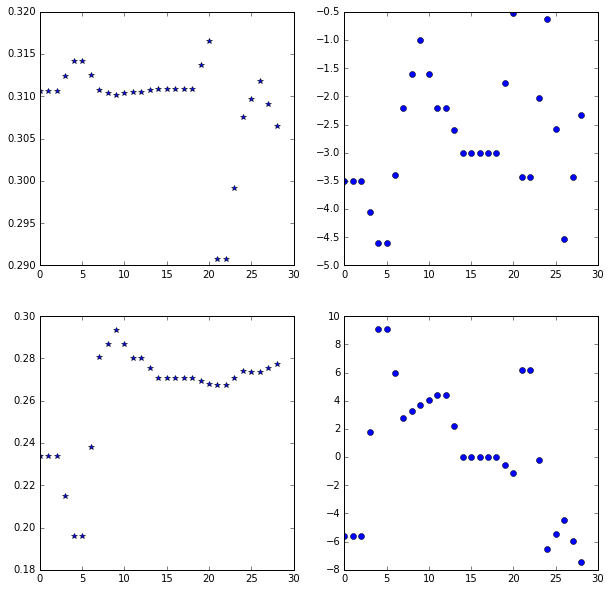

In [15]:
fig,ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].plot(P1K1_amp, '*')
ax[0,1].plot(P1K1_pha, 'o')
ax[1,0].plot(K2S2_amp, '*')
ax[1,1].plot(K2S2_pha, 'o')

In [16]:
# function for fitting 6 frequencies and inferring 2 with constant
def sixplustwo(xplus, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 N2amp, N2pha, Q1amp, Q1pha, Constant):
    x = xplus[0]

    P1K1amp = xplus[1]
    P1K1pha = xplus[2]
    K2S2amp = xplus[3]
    K2S2pha = xplus[4]
    
    return (M2amp * M2ft * np.cos(M2freq*x - (M2pha - M2uvt) *np.pi/180.) +
             K1amp * K1ft * np.cos(K1freq*x - (K1pha - K1uvt) *np.pi/180.) +
             O1amp * O1ft * np.cos(O1freq*x - (O1pha - O1uvt) *np.pi/180.) +
             S2amp * S2ft * np.cos(S2freq*x - (S2pha - S2uvt) *np.pi/180.) +
             P1K1amp * K1amp *P1ft * np.cos(P1freq*x - (K1pha + P1K1pha - P1uvt) *np.pi/180.) +
             N2amp * N2ft * np.cos(N2freq*x - (N2pha - N2uvt) *np.pi/180.) +
             Q1amp * Q1ft * np.cos(Q1freq*x - (Q1pha - Q1uvt) *np.pi/180.) +
             K2S2amp * S2amp *K2ft * np.cos(K2freq*x - (S2pha + K2S2pha - K2uvt) *np.pi/180.) + Constant )

In [17]:
# Testing to Find the Time Shift
print (path+runname)
fPA = NC.Dataset(path+runname+'/PointAtkinson.nc')
#nc_tools.show_dataset_attrs(fPA)
nc_tools.show_variables(fPA)
nc_tools.show_variable_attrs(fPA,'time_counter')
print (fPA.variables['time_counter'][0]-00.)
print (fPA.variables['time_counter'][1]-fPA.variables['time_counter'][0])
print (fPA.variables['time_centered'][0])

fPO = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/myResults/oldtopog/PointAtkinson.nc')
nc_tools.show_variable_attrs(fPO,'time_counter')
print (fPO.variables['time_counter'][0])

/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3
odict_keys(['nav_lat', 'nav_lon', 'bounds_lon', 'bounds_lat', 'area', 'sossheig', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds'])
<class 'netCDF4._netCDF4.Variable'>
float64 time_counter(time_counter)
    axis: T
    standard_name: time
    long_name: Time axis
    calendar: gregorian
    units: seconds since 1900-01-01 00:00:00
    time_origin: 1900-01-01 00:00:00
    bounds: time_counter_bounds
unlimited dimensions: time_counter
current shape = (5760,)
filling off

3668717100.0
600.0
3668717100.0
<class 'netCDF4._netCDF4.Variable'>
float64 time_counter(time_counter)
    axis: T
    standard_name: time
    units: seconds since 2003-04-21 00:00:00
    calendar: gregorian
    title: Time
    long_name: Time axis
    time_origin:  2003-APR-21 00:00:00
    bounds: time_counter_bnds
unlimited dimensions: time_counter
current shape = (3840,)
filling on, default _FillValue of 9.969209968386

Now we can apply this fit to our model output.

### Use Full Time Series for Best Estimate of Amplitudes/Phases

In [18]:
#allocate space for our arrays
M2_amp=[]; M2_pha=[]; K1_amp=[]; K1_pha=[]
O1_amp=[]; O1_pha=[]; S2_amp=[]; S2_pha=[]
N2_amp=[]; N2_pha=[]
Q1_amp=[]; Q1_pha=[]

M2_amp_obs=np.zeros(numsta); M2_pha_obs=np.zeros(numsta)
N2_amp_obs=np.zeros(numsta); N2_pha_obs=np.zeros(numsta)
Q1_amp_obs=np.zeros(numsta); Q1_pha_obs=np.zeros(numsta)
O1_amp_obs=np.zeros(numsta); O1_pha_obs=np.zeros(numsta)

ts = 240
te = ssh.shape[0]
timeplus = np.zeros([5,te-ts])

for stn in range(numsta):
    print (name+stations[stn])
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = (fT1.variables["time_counter"][ts:te]-timeinc)/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]
    timeplus[0] = time
    timeplus[1] = P1K1_amp[stn]*np.ones_like(time); timeplus[2] = P1K1_pha[stn]*np.ones_like(time)
    timeplus[3] = K2S2_amp[stn]*np.ones_like(time); timeplus[4] = K2S2_pha[stn]*np.ones_like(time)

    fitted, cov = curve_fit(sixplustwo,timeplus,ssh[ts:te]) 
    if fitted[0] < 0:
        fitted[0] = -fitted[0]
        fitted[1] = fitted[1]+180

    M2_amp.append(fitted[0])
    pha = fitted[1]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha+360
    if stn == 6:
        print (pha)
    M2_pha.append(pha)

    if fitted[2] < 0:
        fitted[2] = - fitted[2]
        fitted[3] = fitted[3] + 180
    K1_amp.append(fitted[2])
    pha = fitted[3]
    if  pha > 360:
        pha = pha-360
    elif pha < 0:
        pha = pha + 360
    K1_pha.append(pha)  
    
    if fitted[4] < 0:
        fitted[4] = -fitted[4]
        fitted[5] = fitted[5]+180
    O1_amp.append(fitted[4])
    pha= fitted[5]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha + 360
    O1_pha.append(pha) 
    
    if fitted[6] < 0:
        fitted[6] = -fitted[6]
        fitted[7] = fitted[7]+180
    S2_amp.append(fitted[6])
    pha= fitted[7]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha + 360
    S2_pha.append(pha) 
    
    if fitted[8] < 0:
            fitted[8] = -fitted[8]
            fitted[9] = fitted[9]+180
    N2_amp.append(fitted[8])
    pha= fitted[9]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha + 360
    N2_pha.append(pha) 
    
    if fitted[10] < 0:
            fitted[10] = -fitted[10]
            fitted[11] = fitted[11]+180
    Q1_amp.append(fitted[10])
    pha= fitted[11]
    if  pha > 360:
        pha=pha-360
    Q1_pha.append(pha) 

    #now the observations
    location=stations_obs[stn]
    M2_amp_obs[stn]=harm_obs.M2_amp[harm_obs.site==location]/100
    M2_pha_obs[stn]=harm_obs.M2_pha[harm_obs.site==location]
    K1_amp_obs[stn]=harm_obs.K1_amp[harm_obs.site==location]/100
    K1_pha_obs[stn]=harm_obs.K1_pha[harm_obs.site==location]
    
    #O1/S2/P1/N2/Q1/K2 are in the other file
    if (harm_other.site==location).any():
        O1_amp_obs[stn]=harm_other.O1_amp[harm_other.site==location]/100
        O1_pha_obs[stn]=harm_other.O1_pha[harm_other.site==location]
        S2_amp_obs[stn]=harm_other.S2_amp[harm_other.site==location]/100
        S2_pha_obs[stn]=harm_other.S2_pha[harm_other.site==location]
        N2_amp_obs[stn]=harm_other.N2_amp[harm_other.site==location]/100
        N2_pha_obs[stn]=harm_other.N2_pha[harm_other.site==location]
        Q1_amp_obs[stn]=harm_other.Q1_amp[harm_other.site==location]/100
        Q1_pha_obs[stn]=harm_other.Q1_pha[harm_other.site==location]
    #Mask the arrays so that we can do statistics without the 0's throwing things off.
    O1_amp_obs =np.ma.masked_values(O1_amp_obs, 0)
    O1_pha_obs =np.ma.masked_values(O1_pha_obs, 0)
    S2_amp_obs =np.ma.masked_values(S2_amp_obs, 0)
    S2_pha_obs =np.ma.masked_values(S2_pha_obs, 0)
    N2_amp_obs =np.ma.masked_values(N2_amp_obs, 0)
    N2_pha_obs =np.ma.masked_values(N2_pha_obs, 0)
    Q1_amp_obs =np.ma.masked_values(Q1_amp_obs, 0)
    Q1_pha_obs =np.ma.masked_values(Q1_pha_obs, 0)

/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/PortRenfrew
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/SheringhamPoint
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/PedderBay
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/Esquimalt
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/Victoria
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/CloverPoint
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/FinnertyCove
355.385899076
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/FulfordHarbour
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/TumboChannel
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/PatosIsland
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/WhalerBay
/ocean/sallen/allen/research/MEOPAR/myResults/NEMO36_Tides/aug2016/a3/Tsawwassen
/oc

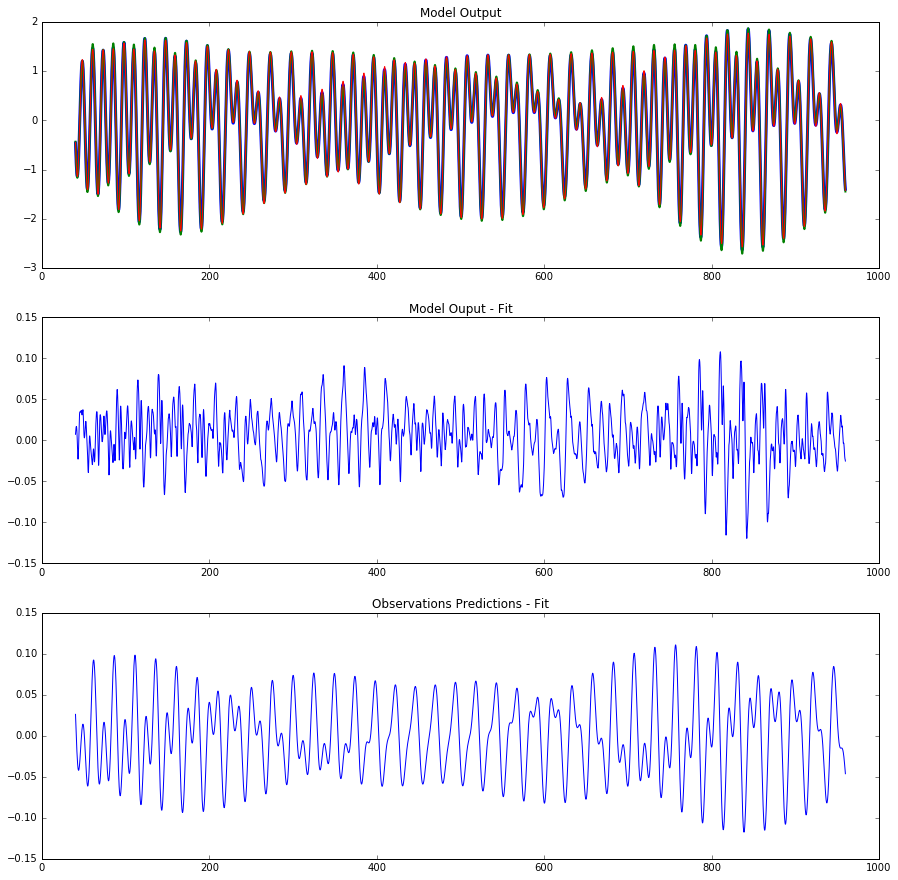

In [19]:
stn = 20
timeplus[0] = time
timeplus[1] = P1K1_amp[stn]*np.ones_like(time); timeplus[2] = P1K1_pha[stn]*np.ones_like(time)
timeplus[3] = K2S2_amp[stn]*np.ones_like(time); timeplus[4] = K2S2_pha[stn]*np.ones_like(time)
thefit = sixplustwo(timeplus, M2_amp[stn], M2_pha[stn], K1_amp[stn], K1_pha[stn], O1_amp[stn], O1_pha[stn], 
                    S2_amp[stn], S2_pha[stn], N2_amp[stn], N2_pha[stn], Q1_amp[stn], Q1_pha[stn], 0.)
theobs = sixplustwo(timeplus, M2_amp_obs[stn], M2_pha_obs[stn], K1_amp_obs[stn], K1_pha_obs[stn], 
                    O1_amp_obs[stn], O1_pha_obs[stn], 
                    S2_amp_obs[stn], S2_pha_obs[stn], N2_amp_obs[stn], N2_pha_obs[stn], 
                    Q1_amp_obs[stn], Q1_pha_obs[stn], 0.)
fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
ssh = fT1.variables["sossheig"][:,0,0]
fig, ax = plt.subplots(3,1,figsize=(15,15))
ax[0].plot(time, thefit, linewidth=3)
ax[0].plot(time, theobs, linewidth=2)
ax[0].plot(time, ssh[ts:te]-0.1)
ax[0].set_title('Model Output')
ax[1].plot(time, ssh[ts:te]-thefit-0.1)
ax[1].set_title('Model Ouput - Fit')
ax[2].plot(time, theobs-thefit)
ax[2].set_title("Observations Predictions - Fit")

The model data is saved in lists M2_amp, M2_pha, K1_amp, K1_pha. We have also saved the observations in M2_amp_obs, etc.

We can compare model and observations by plotting.

In [20]:
print (M2_pha[4], M2_pha[14], M2_pha[14]-M2_pha[4]+360)

316.49701681 31.6052722036 75.1082553933


In [21]:
print (M2_pha_obs[4], M2_pha_obs[14], M2_pha_obs[14]+360-M2_pha_obs[4])

316.1 31.2 75.1


In [22]:
print (M2_amp_obs)

[ 0.708  0.487  0.342  0.367  0.373  0.403  0.447  0.582  0.726  0.68
  0.834  0.811  0.869  0.945  0.918  0.947  0.964  0.988  1.007  1.022
  1.013  0.825  0.556  0.615  0.946  0.935  0.903  1.17   1.171]


0.9484 mean amp obs
SoG [-1.87025511 -0.06053834  2.80854685 -0.4052722  -1.92964032 -0.56895114
 -0.58900009  0.81080614  1.75536503  1.04547418]
1.02523191499 Amp
0.0996535008188 Pha
North [ 1.14357233 -2.2965799 ]
0.995211660436
-0.576503787485


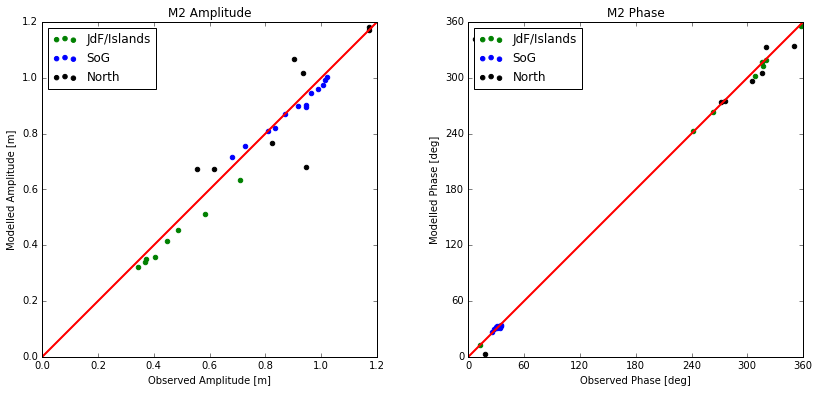

In [40]:
#Plotting M2
labels=['JdF/Islands','SoG','North']
fig=tidetools.plot_scatter_pha_amp(M2_amp,M2_amp_obs,M2_pha,M2_pha_obs,'M2',figsize=(14,6),
                                   split1=split1,split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

SoGratio = np.mean(M2_amp_obs[SoG1:SoG2+1]/M2_amp[SoG1:SoG2+1])
print (np.mean(M2_amp_obs[SoG1:SoG2+1]), 'mean amp obs')
print ("SoG",  M2_pha_obs[SoG1:SoG2+1]-M2_pha[SoG1:SoG2+1])


TSout['West']['M2']['Amp'] = SoGratio
TSout['West']['M2']['Pha'] =  np.mean(M2_pha_obs[SoG1:SoG2+1]-M2_pha[SoG1:SoG2+1])

TSout['North']['M2']['Amp'] = np.mean(M2_amp_obs[-2:]/M2_amp[-2:])
TSout['North']['M2']['Pha'] = np.mean(M2_pha_obs[-2:]-M2_pha[-2:]) 

print (SoGratio, 'Amp')
print (TSout['West']['M2']['Pha'], 'Pha')

print ("North", M2_pha_obs[-2:]-M2_pha[-2:])

print (TSout['North']['M2']['Amp']) 
print (TSout['North']['M2']['Pha']) 

SoG [ 2.45708339  3.19710193  3.55283499  3.58815173  1.90753334  2.64275277
  2.98133815  2.9809345   3.78031242  2.95522995]
1.03893978114
3.00432731563
North [ 3.09572844  1.62364673]
0.95515058194
2.35968758281


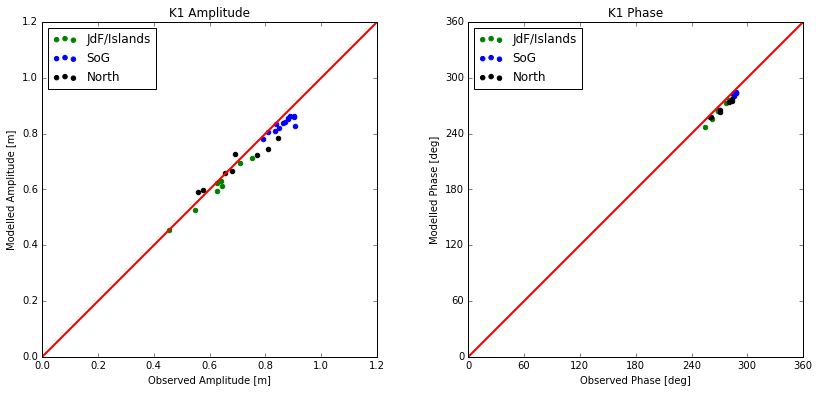

In [43]:
#Plotting - K1

fig=tidetools.plot_scatter_pha_amp(K1_amp,K1_amp_obs,K1_pha,K1_pha_obs,'K1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

TSout['West']['K1']['Amp'] = np.mean(K1_amp_obs[SoG1:SoG2+1]/K1_amp[SoG1:SoG2+1])
TSout['West']['K1']['Pha'] = np.mean(K1_pha_obs[SoG1:SoG2+1]-K1_pha[SoG1:SoG2+1])

TSout['North']['K1']['Amp'] = np.mean(K1_amp_obs[-2:]/K1_amp[-2:])
TSout['North']['K1']['Pha'] = np.mean(K1_pha_obs[-2:]-K1_pha[-2:])

print ("SoG",  K1_pha_obs[SoG1:SoG2+1]-K1_pha[SoG1:SoG2+1])
print (TSout['West']['K1']['Amp'])
print (TSout['West']['K1']['Pha'])

print ("North", K1_pha_obs[-2:]-K1_pha[-2:])
print (TSout['North']['K1']['Amp'] )
print (TSout['North']['K1']['Pha'] )

SoG [-0.5975415986284247 -- -- 0.8677171629117879 -- -- -- -- --
 0.48296397441708905]
1.00478838755
0.2510465129
North [-- 1.5417446242128676]
0.959809304551
1.54174462421


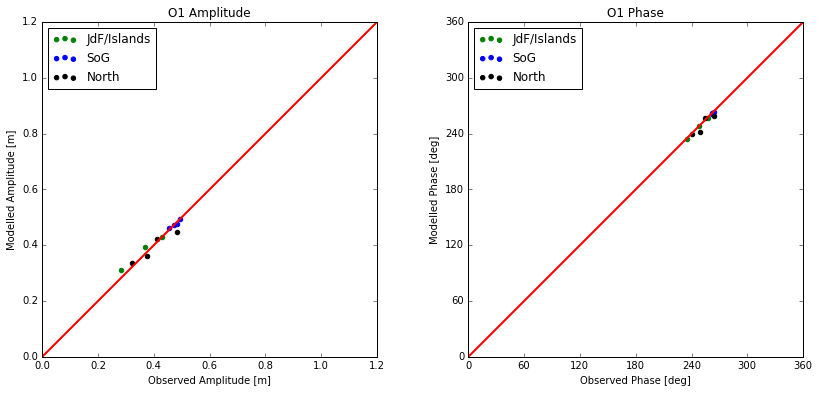

In [44]:
#Plotting - O1

fig=tidetools.plot_scatter_pha_amp(O1_amp,O1_amp_obs,O1_pha,O1_pha_obs,'O1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

TSout['West']['O1']['Amp'] = np.mean(O1_amp_obs[SoG1:SoG2+1]/O1_amp[SoG1:SoG2+1])
TSout['West']['O1']['Pha'] = np.mean(O1_pha_obs[SoG1:SoG2+1]-O1_pha[SoG1:SoG2+1])

TSout['North']['O1']['Amp'] = np.mean(O1_amp_obs[-2:]/O1_amp[-2:])
TSout['North']['O1']['Pha'] = np.mean(O1_pha_obs[-2:]-O1_pha[-2:])

print ("SoG",  O1_pha_obs[SoG1:SoG2+1]-O1_pha[SoG1:SoG2+1])
print (TSout['West']['O1']['Amp'])
print (TSout['West']['O1']['Pha'])

print ("North", O1_pha_obs[-2:]-O1_pha[-2:])
print (TSout['North']['O1']['Amp'] )
print (TSout['North']['O1']['Pha'] )

SoG [-2.5584644823707166 -- -- -1.5135557004202482 -- -- -- -- --
 0.8951108395933787]
1.01749330708
-1.05896978107
North [-- -0.2970435601788495]
0.984780181146
-0.297043560179


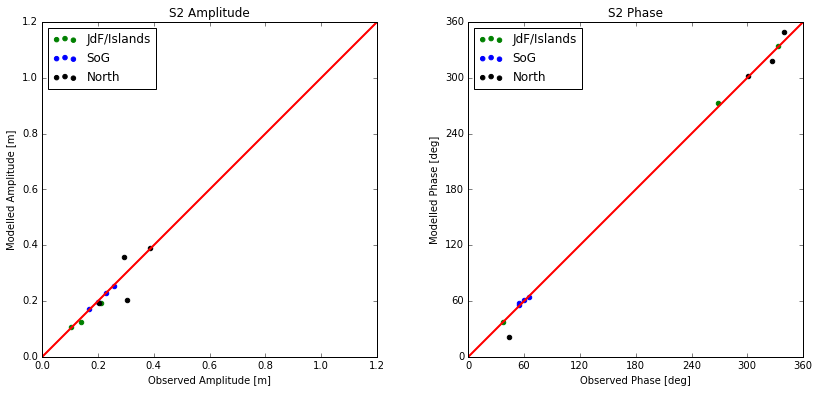

In [45]:
#Plotting - S2

fig=tidetools.plot_scatter_pha_amp(S2_amp,S2_amp_obs,S2_pha,S2_pha_obs,'S2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

TSout['West']['S2']['Amp'] = np.mean(S2_amp_obs[SoG1:SoG2+1]/S2_amp[SoG1:SoG2+1])
TSout['West']['S2']['Pha'] = np.mean(S2_pha_obs[SoG1:SoG2+1]-S2_pha[SoG1:SoG2+1])

TSout['North']['S2']['Amp'] = np.mean(S2_amp_obs[-2:]/S2_amp[-2:])
TSout['North']['S2']['Pha'] = np.mean(S2_pha_obs[-2:]-S2_pha[-2:])

print ("SoG",  S2_pha_obs[SoG1:SoG2+1]-S2_pha[SoG1:SoG2+1])
print (TSout['West']['S2']['Amp'])
print (TSout['West']['S2']['Pha'])

print ("North", S2_pha_obs[-2:]-S2_pha[-2:])
print (TSout['North']['S2']['Amp'] )
print (TSout['North']['S2']['Pha'] )

SoG [-0.4392014601716802 -- -- 0.3768063515847091 -- -- -- -- --
 4.368144269294874]
1.03666737869
1.43524972024
North [-- -0.4472700954557354]
0.989856403354
-0.447270095456


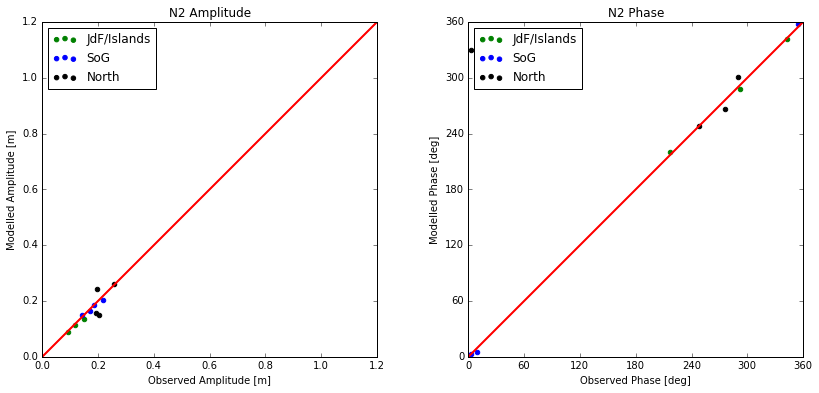

In [47]:
#Plotting - N2

fig=tidetools.plot_scatter_pha_amp(N2_amp,N2_amp_obs,N2_pha,N2_pha_obs,'N2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

TSout['West']['N2']['Amp'] = np.mean(N2_amp_obs[SoG1:SoG2+1]/N2_amp[SoG1:SoG2+1]) 
TSout['West']['N2']['Pha'] = np.mean(N2_pha_obs[SoG1:SoG2+1]-N2_pha[SoG1:SoG2+1])

TSout['North']['N2']['Amp'] = np.mean(N2_amp_obs[-2:]/N2_amp[-2:])
TSout['North']['N2']['Pha'] = np.mean(N2_pha_obs[-2:]-N2_pha[-2:])

print ("SoG",  N2_pha_obs[SoG1:SoG2+1]-N2_pha[SoG1:SoG2+1])
print (TSout['West']['N2']['Amp'])
print (TSout['West']['N2']['Pha'])

print ("North", N2_pha_obs[-2:]-N2_pha[-2:])
print (TSout['North']['N2']['Amp'] )
print (TSout['North']['N2']['Pha'] )

SoG [1.4922866612504322 -- -- 0.6026583760090034 -- -- -- -- --
 0.2593608315252709]
0.98515779296
0.784768622928
North [-- 2.0368378357889867]
0.963333521878
2.03683783579


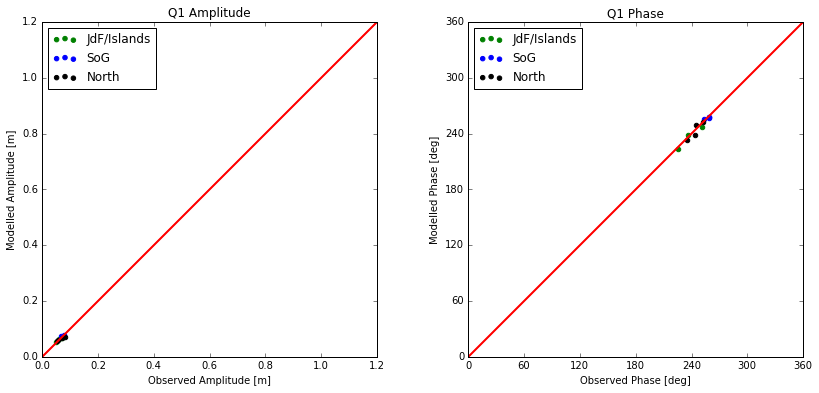

In [48]:
#Plotting - Q1

fig=tidetools.plot_scatter_pha_amp(Q1_amp,Q1_amp_obs,Q1_pha,Q1_pha_obs,'Q1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)


TSout['West']['Q1']['Amp'] = np.mean(Q1_amp_obs[SoG1:SoG2+1]/Q1_amp[SoG1:SoG2+1])
TSout['West']['Q1']['Pha'] = np.mean(Q1_pha_obs[SoG1:SoG2+1]-Q1_pha[SoG1:SoG2+1]) 

TSout['North']['Q1']['Amp'] = np.mean(Q1_amp_obs[-2:]/Q1_amp[-2:])
TSout['North']['Q1']['Pha'] = np.mean(Q1_pha_obs[-2:]-Q1_pha[-2:]) 

print ("SoG",  Q1_pha_obs[SoG1:SoG2+1]-Q1_pha[SoG1:SoG2+1])
print (TSout['West']['Q1']['Amp'])
print (TSout['West']['Q1']['Pha']) 

print ("North", Q1_pha_obs[-2:]-Q1_pha[-2:])
print (TSout['North']['Q1']['Amp'] )
print (TSout['North']['Q1']['Pha'] )

The model performs well when the dots are close to the red line.

In [49]:
print (TSout)

{'West': {'N2': {'Pha': 1.4352497202359678, 'Amp': 1.036667378692899}, 'M2': {'Pha': 0.099653500818837767, 'Amp': 1.025231914991442}, 'O1': {'Pha': 0.25104651290015073, 'Amp': 1.0047883875525667}, 'K1': {'Pha': 3.0043273156281316, 'Amp': 1.0389397811407262}, 'Q1': {'Pha': 0.78476862292823546, 'Amp': 0.98515779295975692}, 'S2': {'Pha': -1.058969781065862, 'Amp': 1.0174933070801107}}, 'North': {'N2': {'Pha': -0.44727009545573537, 'Amp': 0.98985640335385539}, 'M2': {'Pha': -0.57650378748485309, 'Amp': 0.99521166043626219}, 'O1': {'Pha': 1.5417446242128676, 'Amp': 0.95980930455126334}, 'K1': {'Pha': 2.3596875828080783, 'Amp': 0.95515058193957436}, 'Q1': {'Pha': 2.0368378357889867, 'Amp': 0.96333352187839449}, 'S2': {'Pha': -0.29704356017884948, 'Amp': 0.98478018114552135}}}


# Statistics

We would like to save some statistics so that we can determine which runs give us the best match with observations. So, we will define some functions that will help us calculate statistics.

### Mean Error (absolute value)

In [50]:
def mean(diff):
    return np.mean(abs(diff))

### RMS Error

In [51]:
def rms(diff):
    return np.sqrt(np.mean(diff**2))

### Complex differences

This is a way of measuring distances in the complex plane. We can think of our tidal amplitude and phase as a point on the complex plane. So we would like to measure the distance between a point given by the model and a point given by the observations. The function below does this.

In [52]:
def complex_diff(Ao,go,Am,gm):
    #calculates complex differences between observations and model
    #Ao, go - amplitude and phase from observations
    #Am, gm - amplitude and phase from model
    D = np.sqrt((Ao*np.cos(np.pi*go/180)-Am*np.cos(np.pi*gm/180))**2 + 
                (Ao*np.sin(np.pi*go/180)-Am*np.sin(np.pi*gm/180))**2)
    
    return D

Some other things we will look at are

$R = \frac{A_m}{A_o}$, the ratio of modelled to observed amplitude and 

$\Delta \phi = \phi_m - \phi_o$, the difference betwen modelled and observed phase.

In [53]:
#R
R_M2 = M2_amp/M2_amp_obs
R_K1 = K1_amp/K1_amp_obs
#delta phi (adjust so between -180, 180)
Dphi_M2 = M2_pha-M2_pha_obs; 
Dphi_M2 = Dphi_M2 -360*(Dphi_M2>180) + 360*(Dphi_M2<-180)
Dphi_K1 = K1_pha-K1_pha_obs
Dphi_K1 = Dphi_K1 -360*(Dphi_K1>180) + 360*(Dphi_K1<-180)
#Complex differences
D_M2= complex_diff(np.array(M2_amp_obs),np.array(M2_pha_obs), np.array(M2_amp),np.array(M2_pha))
D_K1= complex_diff(np.array(K1_amp_obs),np.array(K1_pha_obs), np.array(K1_amp),np.array(K1_pha))
D_O1= complex_diff(np.ma.array(O1_amp_obs),np.ma.array(O1_pha_obs), np.ma.array(O1_amp),np.ma.array(O1_pha))
D_S2= complex_diff(np.ma.array(S2_amp_obs),np.ma.array(S2_pha_obs), np.ma.array(S2_amp),np.ma.array(S2_pha))
D_N2= complex_diff(np.ma.array(N2_amp_obs),np.ma.array(N2_pha_obs), np.ma.array(N2_amp),np.ma.array(N2_pha))
D_Q1= complex_diff(np.ma.array(Q1_amp_obs),np.ma.array(Q1_pha_obs), np.ma.array(Q1_amp),np.ma.array(Q1_pha))
print (D_M2[2:6], np.mean(D_M2[2:6]))

[ 0.03769267  0.03795171  0.0222796   0.04698941] 0.0362283494517


# Saving the results

We will now save these statistics in a spreadsheet

In [46]:
outfile = runname+'.csv'

with open(outfile, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow([
            'Station Name', 
            'R (M2)', 'Delta phi (M2)', 'D (M2)',
            'R (K1)', 'Delta phi (K1)', 'D (K1)'
        ])
    for stn in range(numsta):
        location = stations_obs[stn]
        writer.writerow([stations_obs[stn],
                        R_M2[stn], Dphi_M2[stn], D_M2[stn],
                        R_K1[stn], Dphi_K1[stn], D_K1[stn]])

    #write averages and rms
    writer.writerow(['Mean Difference',
                    mean(M2_amp-M2_amp_obs),mean(Dphi_M2),mean(D_M2), 
                    mean(K1_amp-K1_amp_obs),mean(Dphi_K1),mean(D_K1)])
    writer.writerow(['RMS Difference',
                    rms(M2_amp-M2_amp_obs),rms(Dphi_M2),rms(D_M2), 
                    rms(K1_amp-K1_amp_obs),rms(Dphi_K1),rms(D_K1)])
    #without the north
    writer.writerow(['Mean Difference no North no PR',
                    mean(M2_amp[1:split2]-M2_amp_obs[1:split2]),mean(Dphi_M2[1:split2]),mean(D_M2[1:split2]), 
                    mean(K1_amp[1:split2]-K1_amp_obs[1:split2]),mean(Dphi_K1[1:split2]),mean(D_K1[1:split2])])
    writer.writerow(['RMS Difference no North no PR',
                    rms(M2_amp[1:split2]-M2_amp_obs[1:split2]),rms(Dphi_M2[1:split2]),rms(D_M2[1:split2]), 
                    rms(K1_amp[1:split2]-K1_amp_obs[1:split2]),rms(Dphi_K1[1:split2]),rms(D_K1[1:split2])])

TypeError: a bytes-like object is required, not 'str'

Now there is a csv file in this directory with data about this run. It should be called runname.csv (where runname is the string we  defined at the beginning of the notebook).

Things to try:
1. Add the complex differences information printed in the .csv file to tide_runs.ods. Also, if you notice any discrepancies, you can correct them. (Check M2 amplitude at Yorke Island)
2. Work through the notebook with a different run. There is a list of runs in tide_runs.ods
3. Commit and push any changes you've made to this notebook and tide_runs.odt.  
Try this:
    * hg status (see what changes have been made)
    * hg in
    * hg commit mynotebook.ipynb (write a commit message and then save and exit)
    * hg commit tide_runs.odt
    * hg pull --rebase
    * pg push
    
4. Add any new csv files to the repository.
Try this:
    * hg add filename.csv
    * hg commit filename.csv
    * hg pull --rebase
    * hg push
    
5. Repeat with all the runs listed in tide_runs.odt

# Plots comparing measured and model amplitudes and phases

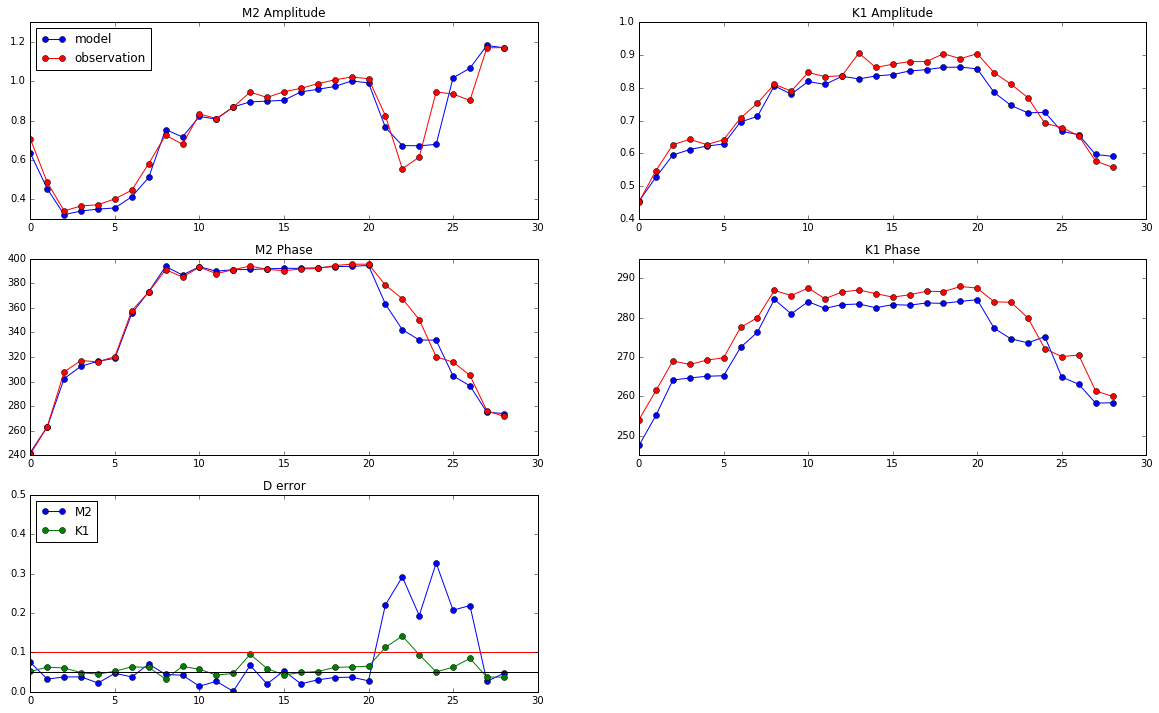

In [54]:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
plt.plot(np.array(M2_amp), '-bo', label = 'model')
plt.plot(M2_amp_obs, 'r-o', label = 'observation')
plt.ylim((0.3,1.3))
plt.title('M2 Amplitude')
plt.legend( loc='upper left' )

plt.subplot(3,2,2)
plt.plot(np.array(K1_amp), '-bo', label = 'model')
plt.plot(K1_amp_obs, 'r-o', label = 'observation')
plt.title('K1 Amplitude')

plt.subplot(3,2,3)
# use the un-wrap function to plot the M2 phase more smoothly
pha_uwm = 180./np.pi * np.unwrap((np.array(M2_pha))*np.pi/180.)
plt.plot(pha_uwm, '-bo', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
plt.plot(pha_uw, 'r-o', label = 'observation')
plt.title('M2 Phase')

plt.subplot(3,2,4)
pha_uw = 180./np.pi * np.unwrap((np.array(K1_pha))*np.pi/180.)
plt.plot(pha_uw, '-bo', label = 'model')
plt.plot(K1_pha_obs, 'r-o', label = 'observation')
plt.ylim((245,295))
plt.title('K1 Phase')

plt.subplot(3,2,5)
plt.plot(D_M2, '-bo', label = 'M2')
plt.plot(D_K1, '-go', label = 'K1')
plt.plot((0,30),(0.05,0.05),'k')
plt.plot((0,30),(0.10,0.10),'r')
plt.ylim((0,0.5))
plt.title('D error')
plt.legend( loc='upper left' )


In [55]:
S_M2_amp =[0.81796594981353787, 0.58179663165988404, 0.32721527983734328, 0.33301854629278987, 0.33182009758572201, 0.33335988978569214, 0.37262690513061936, 0.47803724001914821, 0.76169885554259253, 0.70303608264417961, 0.83441811463548532, 0.81038178372584047, 0.88924863927669251, 0.92291668835873131, 0.92528642573620279, 0.92708554337687221, 0.97186745021953891, 0.99008962519318389, 1.0104938653574274, 1.0424872258774132, 1.0339748559161059, 0.81647033002975733, 0.62855943384043089, 0.6281276494314838, 0.59982497040887706, 0.91766195442050613, 0.98470695914773221, 1.1750995194900644, 1.1641418000518871]
S_M2_pha =[231.70087338077767, 246.8346272505064, 280.61345724675436, 294.01113561226316, 298.32945634086707, 302.34910604358527, 349.45735869033183, 9.6187167682703034, 33.026761185393298, 25.25761537536448, 32.142427075739192, 28.724244493671563, 29.854819687552208, 30.589764003661628, 30.716301323815514, 30.845594548277688, 31.352881756715988, 31.583460490483901, 32.581761034889155, 32.88157718881746, 33.349768476521263, 18.907952568145106, 357.37521447974547, 344.966653323424, 351.41260102119486, 310.27266040290533, 299.6131712504702, 274.6100536345358, 273.39389940946035]
S_K1_amp =[0.46620238668937491, 0.54775592624668346, 0.62336982624343718, 0.63973158805461383, 0.65184922440835646, 0.66057847399548664, 0.72550375684688451, 0.75355773256988012, 0.84304869161948126, 0.82304770052036202, 0.8564923283826591, 0.84454355069955411, 0.86725095546444986, 0.87129988589140794, 0.86593626071139251, 0.87399549321899139, 0.88682087783902708, 0.89052058701213388, 0.89968632710580798, 0.90846210405972316, 0.91010616927977983, 0.84667321748426194, 0.79016417661225991, 0.75020026652394067, 0.79220776158699524, 0.66728988733516137, 0.64016020034578169, 0.56781550023732319, 0.5644943600526271]
S_K1_pha =[249.16405591522613, 257.05973209735021, 266.58707764365994, 267.05565730516582, 267.3703139483444, 267.57406182793716, 275.3147133634908, 279.37270299241624, 287.55876409635982, 284.10168038262879, 287.02142153805926, 284.99250055965047, 285.91139251534031, 286.31767919206936, 285.53519011464579, 286.15531294135207, 285.95283693592955, 286.94132412236769, 286.58602905644142, 286.95109254814417, 287.2626660314782, 284.94162283332389, 282.4623568253017, 279.60944497950373, 283.00778612693961, 270.05868447585368, 267.32225157060719, 261.00793896779192, 261.23071856768365]
S_D_M2 =[ 0.16625969,  0.17951281,  0.15906926,  0.14399509,  0.11621831,  0.13389999,
  0.09472401,  0.10776225,  0.04434292,  0.02324491,  0.01103787,  0.01309181,
  0.02582918,  0.05829261,  0.01065969,  0.02335071,  0.00825068,  0.00585006,
  0.03045116,  0.04977764,  0.04220142,  0.01121144,  0.1262386,   0.0603622,
  0.53398219,  0.09257765,  0.12175468,  0.03495713,  0.03319541]
S_D_K1 = [ 0.04172159,  0.04244914,  0.02657573,  0.01213842,  0.03215966,  0.03138739,
  0.03245773,  0.00826599,  0.03342904,  0.03920169,  0.01186245,  0.01091408,
  0.03149171,  0.03627737,  0.0093824,   0.01469177,  0.00721647,  0.01116176,
  0.00431927,  0.02450076,  0.00716952,  0.01392518,  0.02894072,  0.02017138,
  0.17277305,  0.01172017,  0.03845835,  0.00998477,  0.01369324]


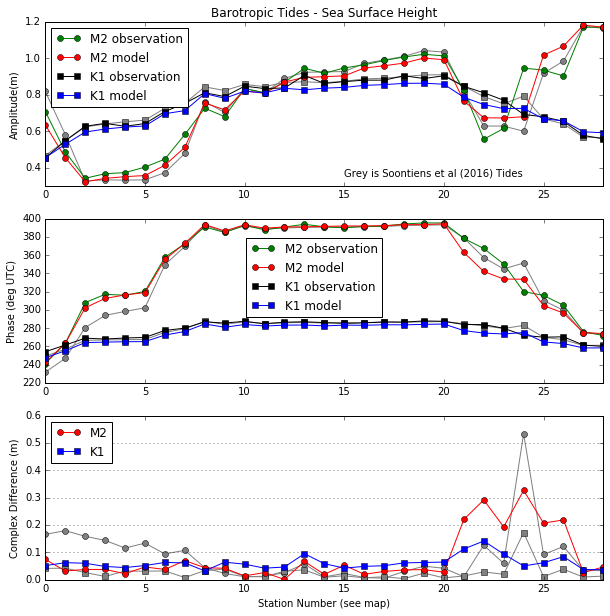

In [56]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(S_M2_amp, '-o', color='grey')
ax[0].plot(S_K1_amp, '-s', color='grey')
ax[0].plot(M2_amp_obs, 'g-o', label = 'M2 observation')
ax[0].plot(np.array(M2_amp), '-ro', label = 'M2 model')
ax[0].plot(K1_amp_obs, 'k-s', label = 'K1 observation')
ax[0].plot(np.array(K1_amp), '-bs', label = 'K1 model')
ax[0].set_title('Barotropic Tides - Sea Surface Height')
ax[0].set_ylabel('Amplitude(m)')
ax[0].legend(loc='upper left')

pha_uw = 180./np.pi * np.unwrap(np.array(S_M2_pha)*np.pi/180.)
ax[1].plot(pha_uw, '-o', color='grey')
pha_uw = 180./np.pi * np.unwrap(np.array(S_K1_pha)*np.pi/180.)
ax[1].plot(pha_uw, '-s', color='grey')
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
ax[1].plot(pha_uw, 'g-o', label = 'M2 observation')
pha_uwm = 180./np.pi * np.unwrap((np.array(M2_pha))*np.pi/180.)
ax[1].plot(pha_uwm, '-ro', label = 'M2 model')
ax[1].plot(K1_pha_obs, 'k-s', label = 'K1 observation')
pha_uw = 180./np.pi * np.unwrap((np.array(K1_pha))*np.pi/180.)
ax[1].plot(pha_uw, '-bs', label = 'K1 model')
ax[1].set_ylabel('Phase (deg UTC)')
ax[1].legend(loc=(0.36, 0.4))

ax[2].plot(S_D_M2, '-o', color = 'grey')
ax[2].plot(S_D_K1, '-s', color = 'grey')
ax[2].plot(D_M2, '-ro', label = 'M2')
ax[2].plot(D_K1, '-bs', label = 'K1')
ax[2].yaxis.grid(True)
ax[2].set_ylim((0,0.6))
ax[2].legend( loc='upper left' )
ax[2].set_ylabel('Complex Difference (m)')
ax[2].set_xlabel('Station Number (see map)')

ax[0].set_xlim((0,28))
ax[2].set_xlim((0,28))
ax[1].set_xlim((0,28))

ax[0].text(15, 0.35, 'Grey is Soontiens et al (2016) Tides')

0.34293675711 0.351589708212
0.37125


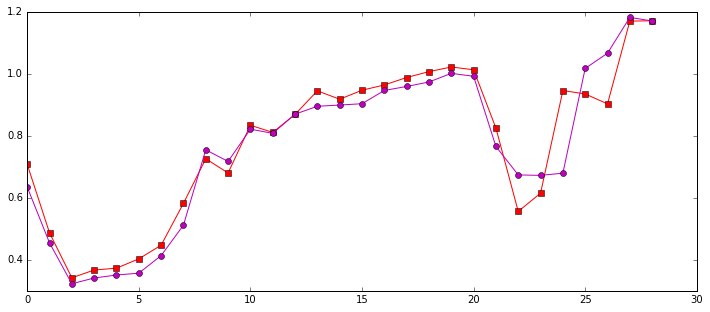

In [57]:
plt.figure(figsize=(12,5))
plt.plot(M2_amp_obs, 'r-s', label = 'observation')
plt.plot(M2_amp, '-mo', label='results')
print (np.mean(M2_amp[2:6]), np.mean(M2_amp[2:6])*SoGratio)
print (np.mean(M2_amp_obs[2:6]))

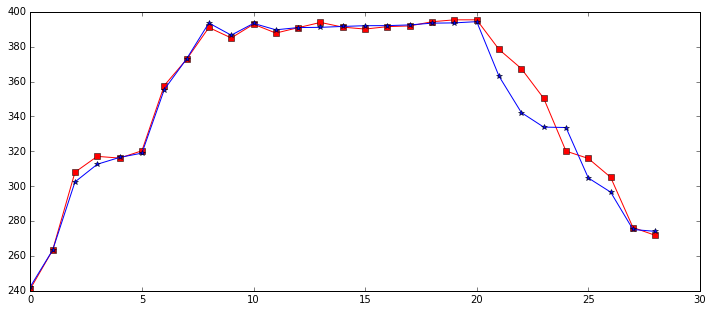

In [58]:
plt.figure(figsize=(12,5))
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
plt.plot(pha_uw, 'r-s', label = 'observation')
pha_uw_mod = 180./np.pi * np.unwrap(np.array(M2_pha)*np.pi/180.)
plt.plot(pha_uw_mod, 'b*-', label='results')

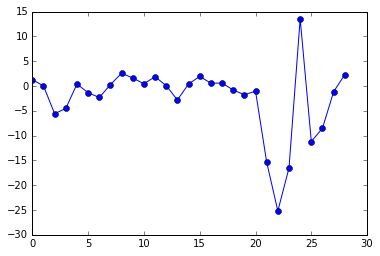

In [59]:
plt.plot(pha_uw_mod-pha_uw, 'bo-')

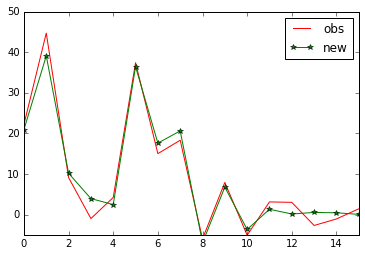

In [60]:
diffy_obs = pha_uw[1:]-pha_uw[0:-1]
diffy_new = pha_uw_mod[1:]-pha_uw_mod[:-1]

plt.plot(diffy_obs,'r',label='obs')
plt.plot(diffy_new,'g*-', label='new')

plt.xlim((0,15))
plt.ylim((-5,50))
plt.legend()

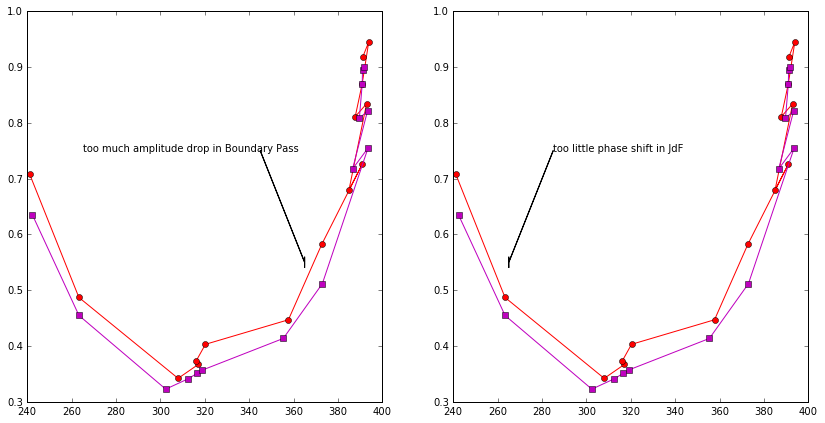

In [61]:
je=15
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(pha_uw[:je], M2_amp_obs[:je],'ro-')
plt.plot(pha_uw_mod[:je],np.array(M2_amp[:je]),'ms-')

plt.arrow(365-20, 0.55+0.2, 20, -0.2)
plt.text(365-100, 0.55+0.2, "too much amplitude drop in Boundary Pass")
plt.subplot(1,2,2)
plt.plot(pha_uw[:je], M2_amp_obs[:je],'ro-')

plt.plot(pha_uw_mod[:je],np.array(M2_amp[:je]),'ms-')
plt.arrow(265+20, 0.55+0.2, -20, -0.2)
plt.text(265+20, 0.55+0.2, "too little phase shift in JdF")

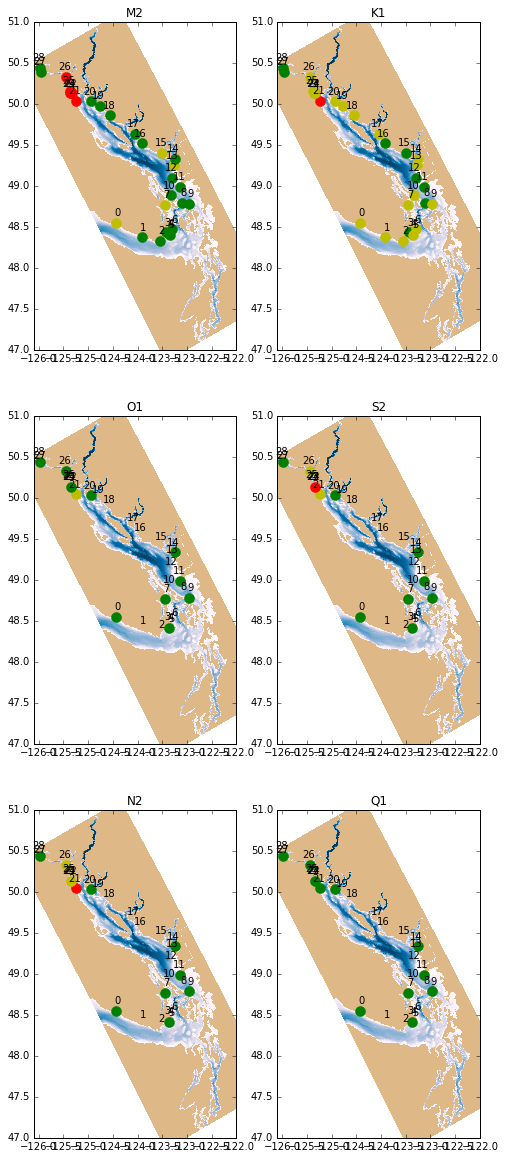

In [62]:
cmap = plt.get_cmap('PuBu')
cmap.set_bad('burlywood')

fig,axs=plt.subplots(3, 2, figsize=(8,20))

constituent = ('M2', 'K1', 'O1', 'S2', 'N2', 'Q1')
error_D = (D_M2, D_K1, D_O1, D_S2, D_N2, D_Q1)


for row in range(3):

    for ax, error_D1, const in zip(axs[row], error_D[row*2:row*2+2], constituent[row*2:row*2+2]):
        ax.pcolormesh(X,Y,bathy,cmap='PuBu')

        for stn in range(numsta):
            location = stations_obs[stn]
            lon=-harm_obs.lon[harm_obs.site==location]
            lat=harm_obs.lat[harm_obs.site==location]
            if error_D1 [stn] <= 0.05:
                ax.plot(lon,lat,'og',label=location,markersize=10,markeredgecolor='g')
            if error_D1 [stn] > 0.1:
                ax.plot(lon,lat,'or',label=location,markersize=10,markeredgecolor='r')
            if 0.1 >= error_D1[stn] > 0.05:
                ax.plot(lon,lat,'oy',label=location,markersize=10,markeredgecolor='y')
        
            ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
                textcoords = 'offset points')
            ax.set_title(const)
        ax.axis([-126.1,-122,47,51])
   



##### First Plot: M2 D error. Second Plot: K1 D error. Markers increase in size as D error increases.

Green: D error <= 0.05, Yellow: 0.05 < D error <= 0.1, Red: D error > 0.1

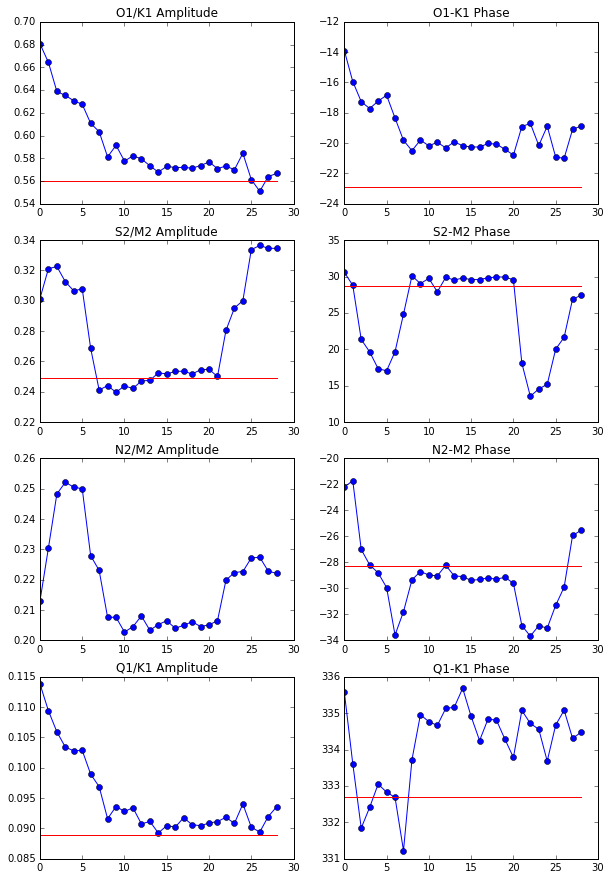

In [63]:
fig, axs = plt.subplots(4,2,figsize=(10,15))
axs[0,0].plot(np.array(O1_amp)/np.array(K1_amp), '-bo', label = 'model')
axs[0,0].plot((0,28),(0.560,0.560), 'r-', label = 'observation')
axs[0,0].set_title('O1/K1 Amplitude')
pha_uw = 180./np.pi * np.unwrap((np.array(O1_pha)-np.array(K1_pha))*np.pi/180.)
axs[0,1].plot(pha_uw, '-bo', label = 'model')
axs[0,1].plot((0,28),(-22.9,-22.9), 'r-', label = 'observation')
axs[0,1].set_title('O1-K1 Phase')

axs[1,0].plot(np.array(S2_amp)/np.array(M2_amp), '-bo', label = 'model')
axs[1,0].plot((0,28),(0.249,0.249), 'r-', label = 'observation')
axs[1,0].set_title('S2/M2 Amplitude')
pha_uw = 180./np.pi * np.unwrap((np.array(S2_pha)-np.array(M2_pha))*np.pi/180.)
axs[1,1].plot(pha_uw, '-bo', label = 'model')
axs[1,1].plot((0,28),( 28.7, 28.7), 'r-', label = 'observation')
axs[1,1].set_title('S2-M2 Phase')

axs[2,0].plot(np.array(N2_amp)/np.array(M2_amp), '-bo', label = 'model')
axs[2,0].plot((0,28),(0.200,0.200), 'r-', label = 'observation')
axs[2,0].set_title('N2/M2 Amplitude')

pha_uw = 180./np.pi * np.unwrap((np.array(N2_pha)-np.array(M2_pha))*np.pi/180.)
axs[2,1].plot(pha_uw, '-bo', label = 'model')
axs[2,1].plot((0,28),(-28.3, -28.3), 'r-', label = 'observation')
axs[2,1].set_title('N2-M2 Phase')

axs[3,0].plot(np.array(Q1_amp)/np.array(K1_amp), '-bo', label = 'model')
axs[3,0].plot((0,28),(0.089,0.089), 'r-', label = 'observation')
axs[3,0].set_title('Q1/K1 Amplitude')

pha_uw = 180./np.pi * np.unwrap((np.array(Q1_pha)-np.array(K1_pha))*np.pi/180.)
axs[3,1].plot(pha_uw+360., '-bo', label = 'model')
axs[3,1].plot((0,28),(-27.3+360,-27.3+360), 'r-', label = 'observation')
axs[3,1].set_title('Q1-K1 Phase')


In [64]:
sample = 17
start = np.zeros(sample)
tend = np.zeros(sample)
for i in range(sample):
    start[i] = 196+(480-196)*np.random.rand()
    tend[i] = te-(480-196)*np.random.rand()
print start
print tend
timelength = (tend-start)/96.
print np.mean(timelength),2*np.std(timelength)
print time[start[1]:tend[1]]


SyntaxError: Missing parentheses in call to 'print' (<ipython-input-64-a5833acb526f>, line 7)

In [ ]:
#allocate space for our arrays
M2_amp=np.zeros((numsta,sample)); M2_pha=np.zeros((numsta,sample))
K1_amp=np.zeros((numsta,sample)); K1_pha=np.zeros((numsta,sample))
O1_amp=np.zeros((numsta,sample)); O1_pha=np.zeros((numsta,sample))
S2_amp=np.zeros((numsta,sample)); S2_pha=np.zeros((numsta,sample))
N2_amp=np.zeros((numsta,sample)); N2_pha=np.zeros((numsta,sample))
Q1_amp=np.zeros((numsta,sample)); Q1_pha=np.zeros((numsta,sample))




for it,tst,tet in zip(range(sample),start.astype(int),tend.astype(int)):
    
    timeplus = np.zeros([5,tet-tst])
  
    for stn in range(numsta):
        fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
        time = (fT1.variables["time_counter"][tst:tet]-timeinc)/3600.  # want hours not seconds
        ssh = fT1.variables["sossheig"][:,0,0]
        timeplus[0] = time
        timeplus[1] = P1K1_amp[stn]*np.ones_like(time); timeplus[2] = P1K1_pha[stn]*np.ones_like(time)
        timeplus[3] = K2S2_amp[stn]*np.ones_like(time); timeplus[4] = K2S2_pha[stn]*np.ones_like(time)        
        
        fitted, cov = curve_fit(sixplustwo,timeplus,ssh[tst:tet]) 
        if fitted[0] < 0:
            fitted[0] = -fitted[0]
            fitted[1] = fitted[1]+180

        M2_amp[stn,it] = fitted[0]
        pha = fitted[1]
        if  pha > 360:
            pha=pha-360
        elif pha < 0:
            pha = pha + 360
        M2_pha[stn,it] = pha
        
        if fitted[2] < 0:
            fitted[2] = -fitted[2]
            fitted[3] = fitted[3]+180

        K1_amp[stn,it] = fitted[2]
        pha= fitted[3]
        if  pha > 360:
            pha=pha-360
        K1_pha[stn,it]= pha   
                
        if fitted[4] < 0:
            fitted[4] = -fitted[4]
            fitted[5] = fitted[5]+180
        O1_amp[stn,it] =fitted[4]
        pha= fitted[5]
        if  pha > 360:
            pha=pha-360
        O1_pha[stn,it]= pha 
        
        if fitted[6] < 0:
            fitted[6] = -fitted[6]
            fitted[7] = fitted[7]+180
        S2_amp[stn,it] =fitted[6]
        pha= fitted[7]
        if  pha > 360:
            pha=pha-360
        S2_pha[stn,it]= pha 
    
        if fitted[8] < 0:
            fitted[8] = -fitted[8]
            fitted[9] = fitted[9]+180
        N2_amp[stn,it] = fitted[8]
        pha= fitted[9]
        if  pha > 360:
            pha=pha-360
        N2_pha[stn,it] = pha
        
        if fitted[10] < 0:
            fitted[10] = -fitted[10]
            fitted[11] = fitted[11]+180
        Q1_amp[stn,it] = fitted[10]
        pha= fitted[11]
        if  pha > 360:
            pha=pha-360
        Q1_pha[stn,it] = pha
        

In [ ]:
jdef = range(3)
south = range(14,18)
north = range(27,29)
print 'M2'
print '     JdeFuca'
print np.mean(M2_amp[jdef]),2*np.std(np.mean(M2_amp[jdef],axis=0))
print np.mean(M2_amp_obs[jdef]), np.mean(M2_amp_obs[jdef])-np.mean(M2_amp[jdef])
print np.mean(M2_amp_obs[jdef])/np.mean(M2_amp[jdef])
print np.mean(M2_pha[jdef]),2*np.std(np.mean(M2_pha[jdef],axis=0))
print np.mean(M2_pha_obs[jdef]), np.mean(M2_pha_obs[jdef])-np.mean(M2_pha[jdef])
print '     South'
print np.mean(M2_amp[south]),2*np.std(np.mean(M2_amp[south],axis=0))
print np.mean(M2_amp_obs[south]), np.mean(M2_amp_obs[south])-np.mean(M2_amp[south])
print np.mean(M2_amp_obs[south])/np.mean(M2_amp[south])
print np.mean(M2_pha[south]),2*np.std(np.mean(M2_pha[south],axis=0))
print np.mean(M2_pha_obs[south]), np.mean(M2_pha_obs[south])-np.mean(M2_pha[south])
print '     North'
print np.mean(M2_amp[north]),2*np.std(np.mean(M2_amp[north],axis=0))
print np.mean(M2_amp_obs[north]), np.mean(M2_amp_obs[north])-np.mean(M2_amp[north])
print np.mean(M2_amp_obs[north])/np.mean(M2_amp[north])
print np.mean(M2_pha[north]),2*np.std(np.mean(M2_pha[north],axis=0))
print np.mean(M2_pha_obs[north]), np.mean(M2_pha_obs[north])-np.mean(M2_pha[north])
print '==============================================='
print 'K1'
print '     JdeFuca'
print np.mean(K1_amp[jdef]),2*np.std(np.mean(K1_amp[jdef],axis=0))
print np.mean(K1_amp_obs[jdef]), np.mean(K1_amp_obs[jdef])-np.mean(K1_amp[jdef])
print np.mean(K1_amp_obs[jdef])/np.mean(K1_amp[jdef])
print np.mean(K1_pha[jdef]),2*np.std(np.mean(K1_pha[jdef],axis=0))
print np.mean(K1_pha_obs[jdef]), np.mean(K1_pha_obs[jdef])-np.mean(K1_pha[jdef])
print '     South'
print np.mean(K1_amp[south]),2*np.std(np.mean(K1_amp[south],axis=0))
print np.mean(K1_amp_obs[south]), np.mean(K1_amp_obs[south])-np.mean(K1_amp[south])
print np.mean(K1_amp_obs[south])/np.mean(K1_amp[south])
print np.mean(K1_pha[south]),2*np.std(np.mean(K1_pha[south],axis=0))
print np.mean(K1_pha_obs[south]), np.mean(K1_pha_obs[south])-np.mean(K1_pha[south])
print '     North'
print np.mean(K1_amp[north]),2*np.std(np.mean(K1_amp[north],axis=0))
print np.mean(K1_amp_obs[north]), np.mean(K1_amp_obs[north])-np.mean(K1_amp[north])
print np.mean(K1_amp_obs[north])/np.mean(K1_amp[north])
print np.mean(K1_pha[north]),2*np.std(np.mean(K1_pha[north],axis=0))
print np.mean(K1_pha_obs[north]), np.mean(K1_pha_obs[north])-np.mean(K1_pha[north])
print '==============================================='

In [ ]:
print 'O1'
print '     South'
print np.mean(O1_amp[south]/K1_amp[south]),2*np.std(np.mean(O1_amp[south]/K1_amp[south],axis=0))
print np.mean(O1_amp_obs[south]/K1_amp_obs[south]), (np.mean(O1_amp_obs[south]/K1_amp_obs[south])
                                                    -np.mean(O1_amp[south]/K1_amp[south]))
print np.mean(O1_amp_obs[south]/K1_amp_obs[south])/np.mean(O1_amp[south]/K1_amp[south])
print np.mean(O1_pha[south]-K1_pha[south]),2*np.std(np.mean(O1_pha[south]-K1_pha[south],axis=0))
print np.mean(O1_pha_obs[south]-K1_pha_obs[south]), (np.mean(O1_pha_obs[south]-K1_pha_obs[south])
                                                     -np.mean(O1_pha[south]-K1_pha[south]))
print '     North'
print np.mean(O1_amp[north]/K1_amp[north]),2*np.std(np.mean(O1_amp[north]/K1_amp[north],axis=0))
print np.mean(O1_amp_obs[north]/K1_amp_obs[north]), (np.mean(O1_amp_obs[north]/K1_amp_obs[north])
                                                    -np.mean(O1_amp[north]/K1_amp[north]))
print np.mean(O1_amp_obs[north]/K1_amp_obs[north])/np.mean(O1_amp[north]/K1_amp[north])
print np.mean(O1_pha[north]-K1_pha[north]),2*np.std(np.mean(O1_pha[north]-K1_pha[north],axis=0))
print np.mean(O1_pha_obs[north]-K1_pha_obs[north]), (np.mean(O1_pha_obs[north]-K1_pha_obs[north])
                                                     -np.mean(O1_pha[north]-K1_pha[north]))
print '==============================================='
print 'S2'
code = ('south','north')
for dir,dire in zip(code,(south,north)):
    print dir
    print np.mean(S2_amp[dire]/M2_amp[dire]),2*np.std(np.mean(S2_amp[dire]/M2_amp[dire],axis=0))
    print np.mean(S2_amp_obs[dire]/M2_amp_obs[dire]), (np.mean(S2_amp_obs[dire]/M2_amp_obs[dire])
                                                    -np.mean(S2_amp[dire]/M2_amp[dire]))
    print np.mean(S2_amp_obs[dire]/M2_amp_obs[dire])/np.mean(S2_amp[dire]/M2_amp[dire])
    unwrap = np.unwrap(np.array(S2_pha)*np.pi/180.)*180./np.pi
    M2_un = np.unwrap(np.array(M2_pha)*np.pi/180.)*180./np.pi
    plt.plot (unwrap[dire],'r',M2_un[dire],'b')
    print np.mean(unwrap[dire]-M2_un[dire])+360.,2*np.std(np.mean(unwrap[dire]-M2_un[dire],axis=0))
    print np.mean(S2_pha_obs[dire]-M2_pha_obs[dire]), (np.mean(S2_pha_obs[dire]-M2_pha_obs[dire])
                                                     -np.mean(unwrap[dire]-M2_un[dire]))-360.

In [ ]:
const = ('Q1', 'N2')
model_amp = (Q1_amp, N2_amp)
model_pha = ()
for const, model_amp, model_pha, obs_amp, obs_pha in zip(('Q1','N2'),
                                                    (Q1_amp, N2_amp),(Q1_pha, N2_pha), 
                                                  (Q1_amp_obs, N2_amp_obs), (Q1_pha_obs, N2_pha_obs)):
    print const
    for dir,dire in zip(code,(south,north)):
        print dir
        print np.mean(model_amp[dire]/K1_amp[dire]),2*np.std(np.mean(model_amp[dire]/K1_amp[dire],axis=0))
        print np.mean(obs_amp[dire]/K1_amp_obs[dire]), (np.mean(obs_amp[dire]/K1_amp_obs[dire])
                                                    -np.mean(model_amp[dire]/K1_amp[dire]))
        print np.mean(obs_amp[dire]/K1_amp_obs[dire])/np.mean(model_amp[dire]/K1_amp[dire])
        unwrap = np.unwrap(np.array(model_pha)*np.pi/180.)*180./np.pi
        K1_un = np.unwrap(np.array(K1_pha)*np.pi/180.)*180./np.pi
        print np.mean(unwrap[dire]-K1_un[dire]),2*np.std(np.mean(unwrap[dire]-K1_un[dire],axis=0))
        print np.mean(obs_pha[dire]-K1_pha_obs[dire]), (np.mean(obs_pha[dire]-K1_pha_obs[dire])
                                                     -np.mean(unwrap[dire]-K1_un[dire]))

In [ ]:
fig,axs = plt.subplots(6,2,figsize=(15,25))
for i in range(sample):
    pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha[:,i])*np.pi/180.)
    axs[0,1].plot(pha_uw ,'-ob', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
axs[0,1].plot(pha_uw, 'r-*', label = 'observation')
axs[0,1].set_title('M2 Phase')
for i in range(sample):
    axs[0,0].plot(M2_amp[:,i], '-bo', label = 'model')
axs[0,0].plot(M2_amp_obs, 'r-*', label = 'observation')
axs[0,0].set_title('M2 Amp')

for i in range(sample):
    if K1_pha[0,i] < -360:
        K1_pha[0,i] = K1_pha[0,i] +720.
    elif K1_pha[0,i] < 0:
        K1_pha[0,i] = K1_pha[0,i] + 360.
    pha_uw = 180./np.pi * np.unwrap(np.array(K1_pha[:,i])*np.pi/180.)
    axs[1,1].plot(pha_uw, '-bo', label = 'model')
axs[1,1].plot(K1_pha_obs, 'r-*', label = 'observation')
axs[1,1].set_title('K1 Phase')
for i in range(sample):
    axs[1,0].plot(K1_amp[:,i], '-bo', label = 'model')
axs[1,0].plot(K1_amp_obs, 'r-*', label = 'observation')
axs[1,0].set_title('K1 Amp')

for i in range(sample):
    if O1_pha[0,i] < 0:
        O1_pha[0,i] = O1_pha[0,i] + 360
    pha_uw = 180./np.pi * np.unwrap(np.array(O1_pha[:,i])*np.pi/180.)
    axs[2,1].plot(pha_uw, '-bo', label = 'model')
axs[2,1].plot(O1_pha_obs, 'r-*', label = 'observation', markersize = 15)
axs[2,1].set_title('O1 Phase')
for i in range(sample):
    axs[2,0].plot(O1_amp[:,i], '-bo', label = 'model')
axs[2,0].plot(O1_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[2,0].set_title('O1 Amp')

for i in range(sample):
    if S2_pha[0,i] < 0:
        S2_pha[0,i] = S2_pha[0,i] + 360
    pha_uw = 180./np.pi * np.unwrap(np.array(S2_pha[:,i])*np.pi/180.)
    axs[3,1].plot(pha_uw, '-bo', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(S2_pha_obs)*np.pi/180.)
vsmall = 1e-6
pha_uwm = np.ma.masked_array(pha_uw, mask=(abs(pha_uw-360)<vsmall))
axs[3,1].plot(pha_uwm, 'r-*', label = 'observation', markersize = 15)
axs[3,1].set_title('S2 Phase')
for i in range(sample):
    axs[3,0].plot(S2_amp[:,i], '-bo', label = 'model')
axs[3,0].plot(S2_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[3,0].set_title('S2 Amp')


for i in range(sample):
    axs[4,0].plot(N2_amp[:,i], '-bo', label = 'model')
axs[4,0].plot(N2_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[4,0].set_title('N2 Amp')
for i in range(sample):
    pha_uw = 180./np.pi * np.unwrap(np.array(N2_pha[:,i])*np.pi/180.)
    axs[4,1].plot(pha_uw, '-bo', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(N2_pha_obs)*np.pi/180.)
pha_uwm = np.ma.masked_array(pha_uw, mask=(abs(pha_uw-360)<vsmall))
axs[4,1].plot(pha_uwm, 'r-*', label = 'observation', markersize = 15)  
axs[4,1].set_title('N2 Phase')

for i in range(sample):
    axs[5,0].plot(Q1_amp[:,i], '-bo', label = 'model')
axs[5,0].plot(Q1_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[5,0].set_title('Q1 Amp')
for i in range(sample):
    pha_uw = 180./np.pi * np.unwrap(np.array(Q1_pha[:,i])*np.pi/180.)
    for j in range(numsta):
        if pha_uw[j] < 0:
            pha_uw[j] += 360
    axs[5,1].plot(pha_uw, '-bo', label = 'model')
axs[5,1].plot(Q1_pha_obs, 'r-*', label = 'observation', markersize = 15)
axs[5,1].set_title('Q1 Phase')
